In [1]:
import signature
import signature.tensor_algebra as ta

print(signature.__file__)
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

/Users/phonedegerland/efmgate/external/signature/signature/__init__.py


In [2]:
import random
import numpy as np
import torch

from efmgate import EfmLSTM
from efmgate import SigLSTM

import numpy as np
import jax
import jax.numpy as jnp
from flax import linen as nn
import optax
import matplotlib.pyplot as plt
# Import des fonctions data
from efmgate import generate_ou_signal, build_dataset, split_data, r2_score
from sklearn.metrics import r2_score ## A revoir

#

## Calcul de signature

In [3]:
from simulation.diffusion import Diffusion

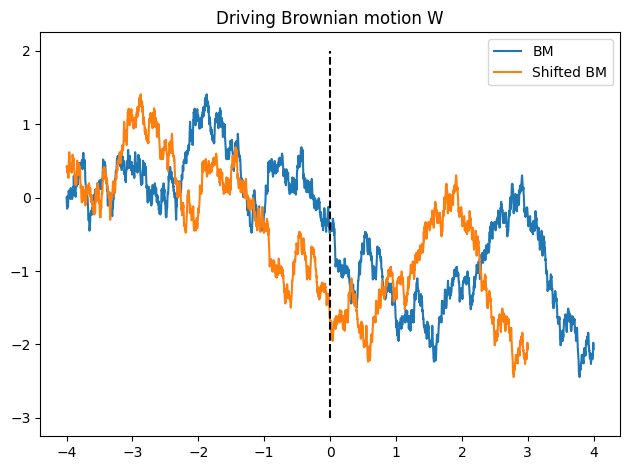

In [5]:
T = 4

t_grid = jnp.linspace(-T, T, (T * 2) * 365 + 1)
rng = np.random.default_rng(seed=4843)
size = 10

diffusion = Diffusion(t_grid=t_grid - t_grid[0], size=size, rng=rng)
W = diffusion.brownian_motion()[0, 0, :]

fig, ax = plt.subplots()

shift = 365
ax.plot(t_grid, W, label="BM")
ax.plot(t_grid[:-shift], W[shift:], label="Shifted BM")
ax.vlines(0, -3, 2, "k", ls='--')
ax.legend()
ax.set_title("Driving Brownian motion W")

fig.tight_layout()
# fig.savefig("shifted_signal.pdf", format="pdf", transparent=True)

In [6]:
t_grid_pos = t_grid[t_grid >= 0]
W_pos = W[t_grid >= 0]

path = np.vstack([t_grid,W]).T
path_pos = np.vstack([t_grid_pos, W_pos]).T
dim = path.shape[1]

In [10]:
N = 1
Sig = ta.path_to_signature(path=path_pos, trunc=N)

In [14]:
lam = jnp.array([10])
SigS1 = ta.path_to_fm_signature(path=path, trunc=N,t_grid=t_grid, lam=lam)

##

# Comparaison LSTM, SIGLSTM ET EFMSIG

In [ ]:


# Random seed

# Random seed

SEED = 1
random.seed(SEED)
np.random.seed(SEED)

# Data generation (OU example)

_, data = generate_ou_signal(T=150, seed=0, kappa=15, theta=0., nu=1.5)
paths, targets = build_dataset(data.reshape(-1, 1))


# Simple LSTM

class SimpleLSTMPredictor(nn.Module):
    units: int = 16
    out_size: int = 1

    @nn.compact
    def __call__(self, x):
        B, T, D = x.shape
        cell = nn.LSTMCell(features=self.units)
        c0 = jnp.zeros((B, self.units))
        h0 = jnp.zeros((B, self.units))
        carry = (c0, h0)
        hs = []

        for t in range(T):
            carry, h = cell(carry, x[:, t, :])
            hs.append(h)
        h_seq = jnp.stack(hs, axis=1)
        return nn.Dense(self.out_size)(h_seq)


# EFM-LSTM (dummy version, same as Simple for example)



class EfmLSTMPredictor(nn.Module):
    units: int = 16
    out_size: int = 1
    signature_depth: int = 3
    signature_input_size: int = 2
    lam: float = 17

    @nn.compact
    def __call__(self, x):
        h = EfmLSTM(self.units, self.signature_depth, self.signature_input_size, self.lam)(x)
        return nn.Dense(self.out_size)(h)


# SIG-LSTM



class SigLSTMPredictor(nn.Module):
    units: int = 16
    out_size: int = 1
    signature_depth: int = 3
    signature_input_size: int = 2

    @nn.compact
    def __call__(self, x):
        h = SigLSTM(self.units, self.signature_depth, self.signature_input_size)(x)
        return nn.Dense(self.out_size)(h)


# Training function

def train_model_epoch_based(model, x_train, y_train, x_val, y_val,
                            epochs=50, lr=0.01, batch_size=10,
                            patience_es=5, min_delta=1e-5, seed=0):
    params = model.init(jax.random.PRNGKey(seed), x_train)
    optimizer = optax.adam(lr)
    opt_state = optimizer.init(params)

    def loss_fn(params, x, y):
        y_pred = model.apply(params, x)
        return jnp.mean((y_pred - y)**2)

    grad_fn = jax.value_and_grad(loss_fn)

    best_val_loss = float("inf")
    best_params = params
    epochs_no_improve = 0
    num_batches = int(np.ceil(x_train.shape[0]/batch_size))

    for epoch in range(epochs):
        perm = np.random.permutation(x_train.shape[0])
        x_train_shuff = x_train[perm]
        y_train_shuff = y_train[perm]

        for i in range(num_batches):
            start = i*batch_size
            end = start+batch_size
            loss, grads = grad_fn(params, x_train_shuff[start:end], y_train_shuff[start:end])
            updates, opt_state = optimizer.update(grads, opt_state)
            params = optax.apply_updates(params, updates)

        val_loss = float(loss_fn(params, x_val, y_val))
        print(f"Epoch {epoch+1} | Val loss: {val_loss:.5f}")

        if best_val_loss - val_loss > min_delta:
            best_val_loss = val_loss
            best_params = params
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience_es:
            print(f"Early stopping at epoch {epoch+1}")
            break

    return model, best_params


# Multi-run experiment

num_runs = 5
results = {"SimpleLSTM": [], "EFM-LSTM": [], "SIG-LSTM": []}
results_rmse = {"SimpleLSTM": [], "EFM-LSTM": [], "SIG-LSTM": []}

for run in range(num_runs):
    print(f"\n=== RUN {run+1} ===")
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = split_data(paths, targets)
    X_train, y_train = jnp.array(X_train), jnp.array(y_train)
    X_val, y_val = jnp.array(X_val), jnp.array(y_val)
    X_test, y_test = jnp.array(X_test), jnp.array(y_test)
    y_test_flat = y_test.reshape(-1)

    # SimpleLSTM
    model = SimpleLSTMPredictor()
    model, params = train_model_epoch_based(model, X_train, y_train, X_val, y_val)
    y_pred = model.apply(params, X_test).reshape(-1)
    results["SimpleLSTM"].append(float(r2_score(y_test_flat, y_pred)))
    results_rmse["SimpleLSTM"].append(float(jnp.sqrt(jnp.mean((y_test_flat - y_pred)**2))))

    # EFM-LSTM
    model = EfmLSTMPredictor()
    model, params = train_model_epoch_based(model, X_train, y_train, X_val, y_val)
    y_pred = model.apply(params, X_test).reshape(-1)
    results["EFM-LSTM"].append(float(r2_score(y_test_flat, y_pred)))
    results_rmse["EFM-LSTM"].append(float(jnp.sqrt(jnp.mean((y_test_flat - y_pred)**2))))

    # SIG-LSTM
    model = SigLSTMPredictor()
    model, params = train_model_epoch_based(model, X_train, y_train, X_val, y_val)
    y_pred = model.apply(params, X_test).reshape(-1)
    results["SIG-LSTM"].append(float(r2_score(y_test_flat, y_pred)))
    results_rmse["SIG-LSTM"].append(float(jnp.sqrt(jnp.mean((y_test_flat - y_pred)**2))))


# Mean results

for model_name in results:
    print(f"{model_name} | Mean R²={np.mean(results[model_name]):.4f}, Mean RMSE={np.mean(results_rmse[model_name]):.4f}")



=== RUN 1 ===
Epoch 1 | Val loss: 0.01714
Epoch 2 | Val loss: 0.01460
Epoch 3 | Val loss: 0.01308
Epoch 4 | Val loss: 0.01307
Epoch 5 | Val loss: 0.01372
Epoch 6 | Val loss: 0.01409
Epoch 7 | Val loss: 0.01395
Epoch 8 | Val loss: 0.01471


In [8]:
results

{'SimpleLSTM': [0.7486456692615331,
  0.7474655337551923,
  0.7350793765218296,
  0.7392943408988073,
  0.7382322179821048],
 'EFM-LSTM': [0.7405313396368858,
  0.7426560697118524,
  0.7403442969980987,
  0.7424900684890225,
  0.7388878703164488],
 'SIG-LSTM': [0.7368015211238019,
  0.7254846615099164,
  0.7179698563677239,
  0.7195723229226428,
  0.7414040400742116]}